## An example of lesion-behavior mapping with CFL

In this notebook, we will run CFL on a simulated dataset of lesion masks and
associated language and visuospatial scores. Lesion masks are generated at 1cm
resolution to keep the example data small and easy to work with. We expect
to recover the established associations that left-hemispheric lesions tend to 
cause language deficits and right-hemispheric lesions tend to cause visuospatial 
deficits (these associations have been built into the artificial data 
generation process).

In [1]:
import os
import pickle
import numpy as np
from source.paths import *
import matplotlib.pyplot as plt

The dataset is stored at `data/simulated`. The code to generate it is at 
`source/generate_data.py`. The saved dataset is comprised of 1000 samples. The 
structure is as follows:

  - X: an (n_samples,n_voxels) 2D array of flattened lesion masks
  - Y: an (n_samples,2) 2D array of language and visuospatial test scores
  - x_coord: an (n_samples,) array of the x-coordinate of the center of each 
    lesion, indicating its position along the left-right axis
      

In [2]:
# load simulated dataset
analysis = 'simulated'
X = np.load(os.path.join(DATA_PATH, analysis, 'X.npy'))
Y = np.load(os.path.join(DATA_PATH, analysis, 'Y.npy'))
x_coord = np.load(os.path.join(DATA_PATH, analysis, 'x_coord.npy'))
print('X shape:', X.shape)
print('Y shape:', Y.shape)
print('x_coord shape:', x_coord.shape)

X shape: (1000, 7942)
Y shape: (1000, 2)
x_coord shape: (1000,)


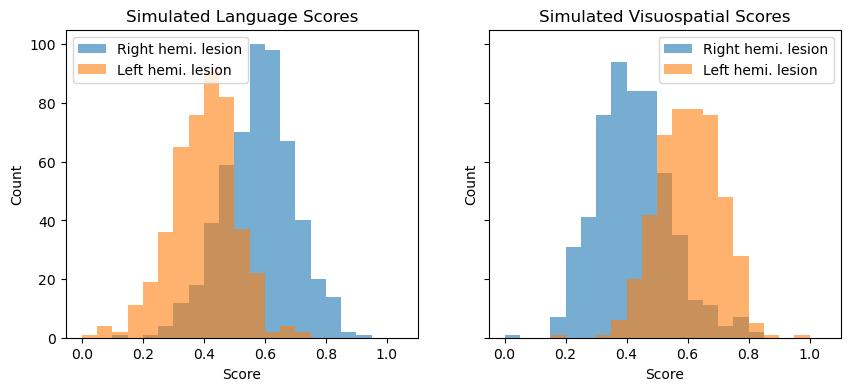

In [3]:
# make histograms of language and visuospatial scores with respect to lesion hemisphere
fig,ax = plt.subplots(1,2,figsize=(10,4), sharex=True, sharey=True)
for i,test_name in enumerate(['Language', 'Visuospatial']):
    ax[i].hist(Y[x_coord>=19//2,i], alpha=0.6, bins=np.arange(0,1.1,0.05))
    ax[i].hist(Y[x_coord<19//2,i], alpha=0.6, bins=np.arange(0,1.1,0.05))
    ax[i].set_title(f'Simulated {test_name} Scores')
    ax[i].set_xlabel('Score')
    ax[i].set_ylabel('Count')
    ax[i].legend(['Right hemi. lesion','Left hemi. lesion'])
plt.show()

`source/run_cfl.py` will use the [CFL software package](https://github.com/eberharf/cfl)
to run CFL on the above data. Hyperparameters for the model are stored in
`source/cfl_params.py` and can be manually changed or set to be automatically 
tuned there.

In [4]:
from source.run_cfl import main as run_cfl
results = run_cfl(analysis='simulated', include_dem=False)

2024-01-07 21:28:23.884742: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


X shape:  (1000, 7942)
Y shape:  (1000, 2)
All results from this run will be saved to /Users/imanwahle/Desktop/cfl_lbm/source/../results/simulated/experiment0000
Block: verbose not specified in input, defaulting to 1
#################### Beginning CFL Experiment training. ####################
Beginning CondDensityEstimator training...
CondDensityEstimator training complete.
Beginning CauseClusterer training...
CauseClusterer training complete.
Experiment training complete.
{'CondDensityEstimator': {'pyx': array([[ 0.47375514,  0.30838883],
       [-0.00154113,  0.00255379],
       [-0.59636528,  0.91661687],
       ...,
       [-0.84870929,  0.84602033],
       [-0.00154113,  0.00255379],
       [-0.6495202 ,  1.28236985]])}, 'CauseClusterer': {'x_lbls': array([0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 

/Users/imanwahle/opt/miniconda3/envs/cfl-lbm/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


The results from CFL will automatically be stored under `results/simulated/experiment000x`.
The resulting lesion categories can be loaded in as follows:

In [5]:
with open(os.path.join(RESULTS_PATH, 
    'simulated/experiment0000/dataset_train/CauseClusterer_results.pickle'), 'rb') as f:
    C = pickle.load(f)['x_lbls']

Finally, we can take the average of all lesion masks in each lesion category
found by CFL to get a sense of what kinds of lesions fall into each category. 
Below, we plot a single horizontal slice out of each average mask.

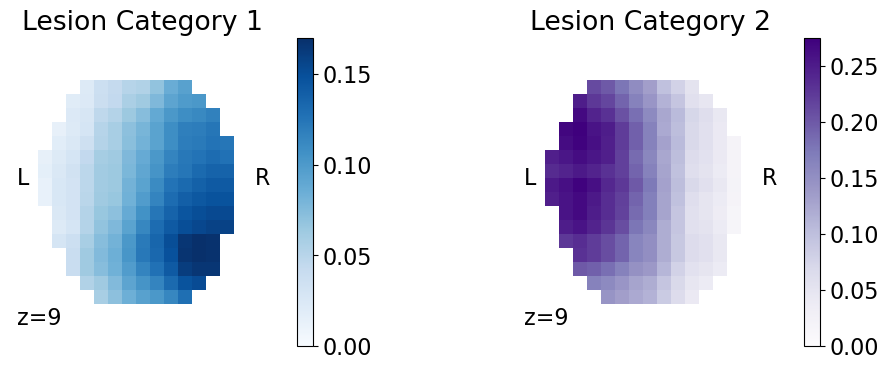

In [6]:
mask_1cm = np.load(os.path.join(DATA_PATH, analysis, 'mask_1cm.npy'))
zslice = 9
colors = ['Blues', 'Purples']
fig,ax = plt.subplots(1,len(np.unique(C)),figsize=(12,4))
for c in np.unique(C):
    Xc = np.mean(X[C==c,:], axis=0)
    Xc = np.reshape(Xc, (19, 22, 19))
    Xc[np.where(mask_1cm==0)]=np.nan
    im = ax[c].imshow(Xc[:,:,zslice].T, cmap=colors[c], vmin=0)
    cbar = fig.colorbar(im, ax=ax[c])
    ax[c].axis('off')
    ax[c].set_title(f'Lesion Category {int(c+1)}')
    # label left and right hemispheres
    ax[c].text(0,  10, 'L', color='black', fontsize=16)
    ax[c].text(17, 10, 'R', color='black', fontsize=16)
    ax[c].text(0,  20, f'z={zslice}', color='black', fontsize=16)

We can also visualize test scores that correspond to the two categories of lesions:

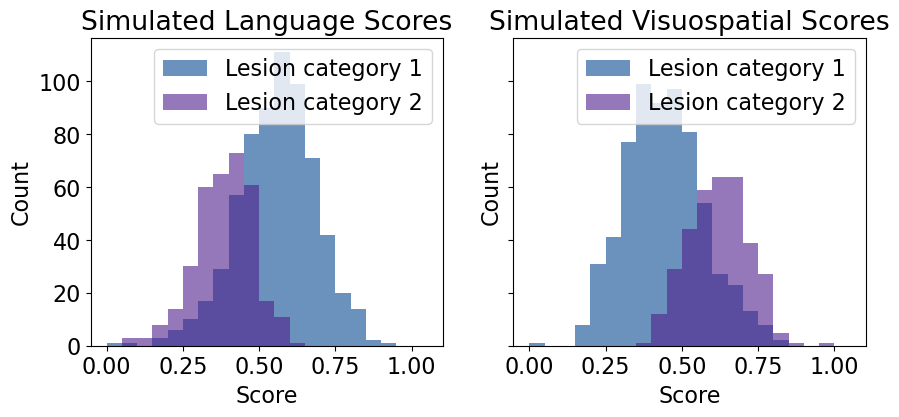

In [7]:
fig,ax = plt.subplots(1,2,figsize=(10,4), sharex=True, sharey=True)
for i,test_name in enumerate(['Language', 'Visuospatial']):
    ax[i].hist(Y[C==0,i], alpha=0.6, bins=np.arange(0,1.1,0.05), color=plt.get_cmap(colors[0])(0.9))
    ax[i].hist(Y[C==1,i], alpha=0.6, bins=np.arange(0,1.1,0.05), color=plt.get_cmap(colors[1])(0.9))
    ax[i].set_title(f'Simulated {test_name} Scores')
    ax[i].set_xlabel('Score')
    ax[i].set_ylabel('Count')
    ax[i].legend(['Lesion category 1','Lesion category 2'])
plt.show()